## Data Cleaning
* Pull the stock data
* remove stocks that were delisted/have an incomplete time series
* Set the rebalancing window (every 15 days as per Yi and Kwon)
* Use exponential weighted covariance and mean as the estimates for MVO (forecasted i.e scaled by T and mean)
* Calculate the realized 15 day returns

In [1]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.cm as cm
from datetime import datetime
import scipy.linalg as la
import yfinance as yf
import pickle as pkl
from pandasql import sqldf
sns.set_style('whitegrid')

%matplotlib inline

From Meucci: https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1586656

a) Take the price series Rt, Rt−1,Rt−2, ..., say weekly, for all the n securities

b) Estimate the n × n covariance matrix Σ of the log returns, say
by exponential smoothing

c) Determine the investment horizon, say k = fifty weeks

d) Project means and covariances to the horizon
µk ≡ kµ, Σk ≡ kΣ

e) Convert log normal returns back to linear returns for portfolio optimization

Exponential smoothing is used in Risk Metrics to estimate the covariance matrix. The same approach is taken here with a weighting given by $\lambda^{T-t}$ where $\lambda = 0.985$


In [10]:
FigSize = (8,8)
### Skip this step if the data has been pulled
# table=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
# df = table[0]
# df.to_csv("S&P500-Symbols.csv", columns=['Symbol'])
sp = pd.read_csv('S&P500-Symbols.csv', index_col=[0])
#data = yf.download(sp.values[:,0].tolist(), start="1999-09-30", end="2020-10-31")
#data.to_pickle("cache/RawPrices.pkl")

[*********************100%***********************]  505 of 505 completed

27 Failed downloads:
- MXIM: No data found for this date range, symbol may be delisted
- CXO: No data found for this date range, symbol may be delisted
- VIAC: No data found for this date range, symbol may be delisted
- DISCA: No data found for this date range, symbol may be delisted
- CERN: No data found for this date range, symbol may be delisted
- ANTM: No data found for this date range, symbol may be delisted
- WLTW: No data found for this date range, symbol may be delisted
- AGN: No data found for this date range, symbol may be delisted
- FLIR: No data found for this date range, symbol may be delisted
- INFO: No data found for this date range, symbol may be delisted
- COG: No data found for this date range, symbol may be delisted
- MYL: No data found for this date range, symbol may be delisted
- ALXN: No data found for this date range, symbol may be delisted
- CTL: No data found for this date range, symbol m

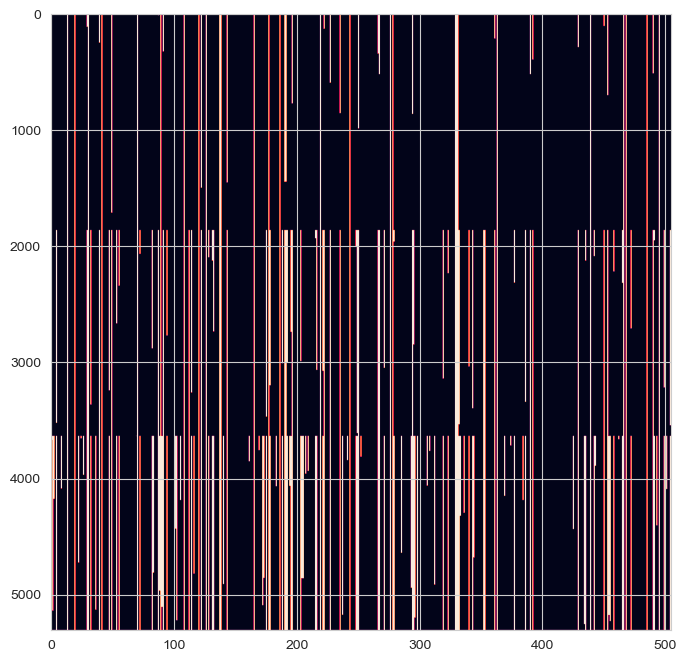

In [11]:
#### Investigate Missing Values
data = pd.read_pickle("cache/RawPrices.pkl")
plt.figure(figsize = FigSize)
plt.imshow(data['Adj Close'].isna().astype(int),aspect='auto');

In [12]:
P = data['Adj Close'].sort_index()
P = P[~P.isna().all(axis=1)] #dropping rows with all missing values
P = P.loc[:,~P.isna().any(axis=0)] #remove any tickers with missing values
P.head()
# brkcol = lambda col: col if 'BRK' in col else ''
# print([brkcol(col) for col in P.columns])

,AAPL,ABC,ABMD,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WMT,WRB,WY,XEL,XOM,XRAY,XRX,YUM,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,
1999-09-30 00:00:00-04:00,0.482663,4.577421,7.7500,9.668555,14.081866,16.619362,6.693834,21.944006,5.262768,12.851358,...,31.574663,1.423076,10.069626,8.183204,18.604370,6.567179,67.801796,5.281898,20.208332,38.006561
1999-10-01 00:00:00-04:00,0.470513,4.565345,8.0000,9.750915,14.043097,17.490866,6.728341,21.575197,5.127439,13.042534,...,32.072548,1.388273,9.785667,8.325520,18.267773,6.152220,69.216446,5.378665,19.916668,36.886173
1999-10-04 00:00:00-04:00,0.492192,4.299636,8.0000,9.915620,14.616918,18.098886,6.624826,22.005466,5.097366,13.233717,...,33.400265,1.376672,9.938566,8.515279,17.869987,6.458930,68.205986,5.507690,19.777779,38.351288
1999-10-05 00:00:00-04:00,0.517922,4.251326,8.0000,9.553258,14.229199,18.058353,6.590322,21.575197,4.962037,13.063776,...,34.022614,1.392140,9.829354,8.372959,17.671093,6.332636,66.488220,5.467368,19.777779,38.825306
1999-10-06 00:00:00-04:00,0.512204,4.203015,7.9375,9.586198,14.461831,18.990669,6.762843,21.821056,5.036837,13.042534,...,34.105621,1.399875,9.873043,8.325520,18.114788,6.350678,68.205986,5.418984,21.680555,39.514771


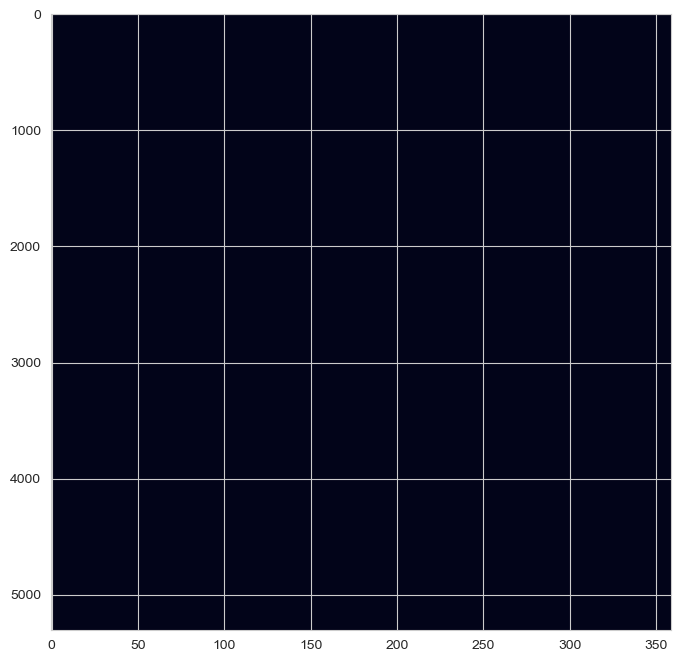

In [13]:
#### No more missing values
plt.figure(figsize = FigSize)
plt.imshow(P.isna().astype(int),aspect='auto');

In [14]:
### Export Tickers for WRDS, since WRDS python API does not have access to fundq dataset from S&P Compustat
pd.Series(P.columns).to_csv('cache/wrds_tickers.csv')

### Wharton Research Data Services Data Prep 

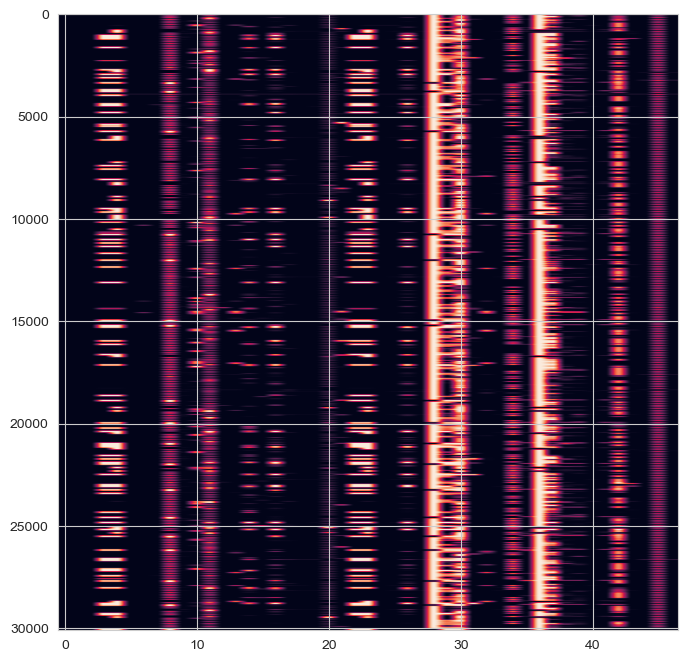

In [15]:
wrds = pd.read_csv('cache/WRDS_OUT.csv')
plt.figure(figsize=FigSize)
plt.imshow(wrds.isna().astype(int),aspect='auto');
wrds['date'] = pd.to_datetime(wrds.datadate, format = '%Y%m%d')

In [16]:
#fix the column names to lower case
wrds.rename(columns=str.lower, inplace = True)
wrds.columns = wrds.columns.str.replace(' ', '')
wrds.head()

,datadate,tic,srcq,actq,ancq,atq,ceqq,cheq,chq,cogsq,...,dltisy,dltry,niy,oancfy,txpdy,txty,dvpspq,mkvaltq,prccq,date
0,19991231,AAPL,5,4909.0,2677.0,7586.0,4264.0,3660.0,NaN,1716.0,...,0.0,0.0,183.0,373.0,8.0,91.0,0.0,NaN,102.8125,1999-12-31
1,20000331,AAPL,5,4912.0,2095.0,7007.0,4065.0,3609.0,NaN,1375.0,...,0.0,0.0,416.0,434.0,37.0,177.0,0.0,NaN,135.8125,2000-03-31
2,20000630,AAPL,5,5157.0,1775.0,6932.0,4026.0,3826.0,NaN,1257.0,...,0.0,0.0,616.0,668.0,36.0,247.0,0.0,NaN,52.3750,2000-06-30
3,20000930,AAPL,5,5427.0,1376.0,6803.0,4031.0,4027.0,NaN,1385.0,...,0.0,0.0,786.0,826.0,47.0,306.0,0.0,NaN,25.7500,2000-09-30
4,20001231,AAPL,5,4926.0,1060.0,5986.0,3709.0,4065.0,NaN,1004.0,...,0.0,0.0,-195.0,-13.0,9.0,-88.0,0.0,NaN,14.8750,2000-12-31


In [ ]:
#for each company, how many quarterly reports are there
ReportCountsbyTicker = wrds.groupby(by = 'tic').count().sort_values(by = 'datadate')
#we do not have data for these companies (3 companies - no data) shown in cell below
P.loc[:,P.columns[~P.columns.isin(ReportCountsbyTicker.index)]]

,BF-B,BRK-B,COG
Date,,,
1999-11-01,4.731973,41.740002,1.202743
1999-11-02,4.688560,42.820000,1.225231
1999-11-03,4.671194,43.060001,1.270313
1999-11-04,4.705925,43.259998,1.283827
1999-11-05,4.753679,42.619999,1.234312
...,...,...,...
2020-10-26,72.064468,208.490005,18.872143
2020-10-27,71.598969,206.880005,18.628191
2020-10-28,68.964386,200.699997,17.730450


,datadate,tic,srcq,actq,ancq,atq,ceqq,cheq,chq,cogsq,cshiq,cshopq,cshoq,cstkq,dlcq,dlttq,dpq,epspi12,epspiq,epspxq,intanq,invtq,lctq,lltq,ltq,niq,oibdpq,opepsq,pllq,ppegtq,recdq,rectq,req,saleq,teqq,capxy,depcy,dlcchy,dltisy,dltry,niy,oancfy,txpdy,txty,dvpspq,mkvaltq,prccq,date
0,19991231,AAPL,5,4909.0,2677.0,7586.0,4264.0,3660.0,NaN,1716.0,161.224,NaN,161.224,1345.0,0.0,300.0,20.0,4.230,1.14,1.14,NaN,15.0,1965.0,1207.0,3172.0,183.0,218.0,1.53,NaN,725.0,NaN,892.0,2919.0,2343.0,NaN,38.0,NaN,0.0,0.0,0.0,183.0,373.0,8.0,91.0,0.00,NaN,102.8125,1999-12-31
1,20000331,AAPL,5,4912.0,2095.0,7007.0,4065.0,3609.0,NaN,1375.0,162.680,NaN,162.680,1419.0,0.0,300.0,21.0,4.670,1.44,1.44,NaN,10.0,1853.0,939.0,2792.0,233.0,191.0,1.44,NaN,723.0,NaN,940.0,2646.0,1945.0,NaN,65.0,NaN,0.0,0.0,0.0,416.0,434.0,37.0,177.0,0.00,NaN,135.8125,2000-03-31
2,20000630,AAPL,5,5157.0,1775.0,6932.0,4026.0,3826.0,NaN,1257.0,324.826,NaN,324.826,1376.0,0.0,300.0,25.0,2.245,0.62,0.62,NaN,5.0,1873.0,883.0,2756.0,200.0,193.0,0.62,NaN,721.0,NaN,967.0,2650.0,1825.0,NaN,76.0,NaN,0.0,0.0,0.0,616.0,668.0,36.0,247.0,0.00,NaN,52.3750,2000-06-30
3,20000930,AAPL,5,5427.0,1376.0,6803.0,4031.0,4027.0,NaN,1385.0,335.677,NaN,335.677,1502.0,0.0,300.0,18.0,2.420,0.52,0.52,NaN,33.0,1933.0,763.0,2696.0,170.0,102.0,0.52,NaN,700.0,NaN,953.0,2529.0,1870.0,NaN,107.0,NaN,0.0,0.0,0.0,786.0,826.0,47.0,306.0,0.00,NaN,25.7500,2000-09-30
4,20001231,AAPL,5,4926.0,1060.0,5986.0,3709.0,4065.0,NaN,1004.0,345.307,NaN,345.307,1578.0,0.0,311.0,24.0,1.280,-0.58,-0.61,NaN,21.0,1637.0,637.0,2274.0,-195.0,-396.0,-0.61,NaN,NaN,NaN,441.0,2131.0,1007.0,NaN,22.0,NaN,0.0,0.0,0.0,-195.0,-13.0,9.0,-88.0,0.00,NaN,14.8750,2000-12-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30091,20190930,ZION,5,NaN,NaN,70361.0,6943.0,2449.0,NaN,120.0,170.373,6.638,170.373,3002.0,4579.0,1492.0,50.0,4.520,1.23,1.23,1014.0,145.0,NaN,NaN,62852.0,222.0,362.0,1.23,10.0,NaN,NaN,48325.0,3941.0,823.0,7509.0,94.0,NaN,-1074.0,497.0,0.0,633.0,346.0,179.0,185.0,0.34,7585.0060,44.5200,2019-09-30
30092,20191231,ZION,5,NaN,NaN,69172.0,6787.0,1932.0,NaN,91.0,165.057,5.529,165.057,2735.0,2053.0,1969.0,45.0,4.410,1.03,1.03,1014.0,137.0,NaN,NaN,61819.0,183.0,334.0,1.03,4.0,NaN,NaN,48214.0,4052.0,799.0,7353.0,117.0,NaN,-3600.0,992.0,0.0,816.0,697.0,233.0,237.0,0.34,8569.7594,51.9200,2019-12-31
30093,20200331,ZION,5,NaN,NaN,71467.0,6906.0,2505.0,NaN,332.0,163.852,1.669,163.852,2668.0,3765.0,2035.0,45.0,3.350,0.04,0.04,1014.0,146.0,NaN,NaN,63995.0,14.0,85.0,0.04,258.0,NaN,NaN,49197.0,4238.0,756.0,7472.0,28.0,NaN,1712.0,0.0,0.0,14.0,153.0,1.0,2.0,0.34,4384.6795,26.7600,2020-03-31
30094,20200630,ZION,5,NaN,NaN,76447.0,7009.0,2415.0,NaN,200.0,163.978,0.011,163.978,2675.0,860.0,1590.0,18.0,2.640,0.34,0.34,1014.0,110.0,NaN,NaN,68872.0,66.0,181.0,0.48,168.0,NaN,NaN,54269.0,4334.0,712.0,7575.0,82.0,NaN,-1194.0,0.0,429.0,80.0,398.0,17.0,18.0,0.34,5575.2520,34.0000,2020-06-30


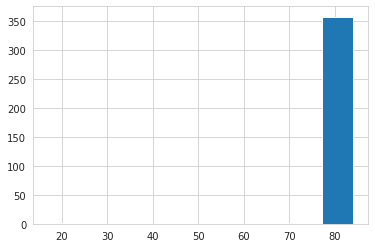

In [ ]:
#these are columns that are in the balance reports
ColumnsCovered =  P.columns[P.columns.isin(ReportCountsbyTicker.index)]

#there are a lot of tickers with decent coverage
plt.hist(ReportCountsbyTicker.loc[ReportCountsbyTicker.index.isin(ColumnsCovered), 'datadate']);
wrds[wrds.tic.isin(ColumnsCovered)]

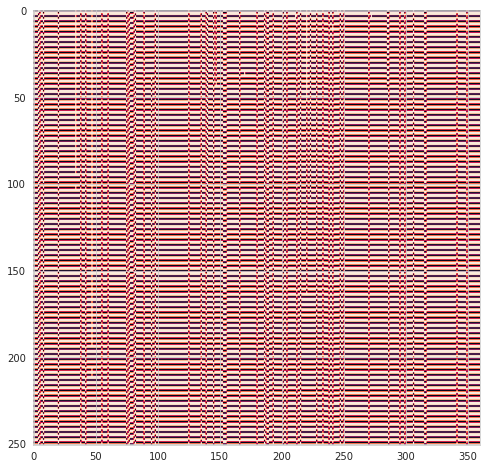

In [ ]:
#the reporting coverage is visualized below
#the y axis is the date and the x axis is the ticker
plt.figure(figsize = FigSize)
wrdsbydate = wrds.loc[wrds.tic.isin(ColumnsCovered),
                                        ['tic', 'date', 'datadate']].pivot(index='date', columns='tic', values='datadate')

plt.imshow(wrdsbydate.isna().astype(int),aspect='auto');

#### for the WRDS data - do a column wise analysis

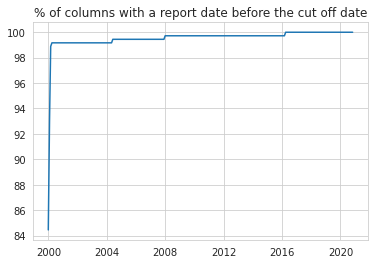

In [ ]:
#for each date: what % of tickers have missing reports? 
dates = np.array([])
stats = np.array([])
wrdsbydate.isna().astype(int)
for date in wrdsbydate.index:
  dates = np.append(dates, date)
  wrdsbydate[:date]
  stats = np.append(stats, 1 - wrdsbydate[:date].isna().all(axis = 0).mean())
#find the % of columns that have a date before the cut off date
plt.plot(dates, 100*stats);
plt.title("% of columns with a report date before the cut off date");

In [ ]:
#from the chart above, pick a threshold of about 2% (i.e keep 98% of tickers) 
#and then set a cut off date for the stock data after that
cut_dt = np.min(dates[stats > 0.98])
columnscovered2 = ~(wrdsbydate[:cut_dt].isna().all(axis = 0))
print('% of columns maintained', sum(columnscovered2)/len(columnscovered2))
wrdsbydate.columns[columnscovered2]

% of columns maintained 0.9888888888888889


Index(['AAPL', 'ABC', 'ABMD', 'ABT', 'ADBE', 'ADI', 'ADM', 'ADP', 'ADSK',
       'AEE',
       ...
       'WRB', 'WY', 'XEL', 'XLNX', 'XOM', 'XRAY', 'XRX', 'YUM', 'ZBRA',
       'ZION'],
      dtype='object', name='tic', length=356)

columns dropped
 ['chq', 'depcy', 'dlcchy', 'pllq', 'txpdy', 'ppegtq', 'recdq']


,datadate,tic,srcq,actq,ancq,atq,ceqq,cheq,cogsq,cshiq,cshopq,cshoq,cstkq,dlcq,dlttq,dpq,epspi12,epspiq,epspxq,intanq,invtq,lctq,lltq,ltq,niq,oibdpq,opepsq,rectq,req,saleq,teqq,capxy,dltisy,dltry,niy,oancfy,txty,dvpspq,mkvaltq,prccq,date
0,19991231,AAPL,5,4909.0,2677.0,7586.0,4264.0,3660.0,1716.0,161.224,NaN,161.224,1345.0,0.0,300.0,20.0,4.230,1.14,1.14,NaN,15.0,1965.0,1207.0,3172.0,183.0,218.0,1.53,892.0,2919.0,2343.0,NaN,38.0,0.0,0.0,183.0,373.0,91.0,0.0,NaN,102.8125,1999-12-31
1,20000331,AAPL,5,4912.0,2095.0,7007.0,4065.0,3609.0,1375.0,162.680,NaN,162.680,1419.0,0.0,300.0,21.0,4.670,1.44,1.44,NaN,10.0,1853.0,939.0,2792.0,233.0,191.0,1.44,940.0,2646.0,1945.0,NaN,65.0,0.0,0.0,416.0,434.0,177.0,0.0,NaN,135.8125,2000-03-31
2,20000630,AAPL,5,5157.0,1775.0,6932.0,4026.0,3826.0,1257.0,324.826,NaN,324.826,1376.0,0.0,300.0,25.0,2.245,0.62,0.62,NaN,5.0,1873.0,883.0,2756.0,200.0,193.0,0.62,967.0,2650.0,1825.0,NaN,76.0,0.0,0.0,616.0,668.0,247.0,0.0,NaN,52.3750,2000-06-30
3,20000930,AAPL,5,5427.0,1376.0,6803.0,4031.0,4027.0,1385.0,335.677,NaN,335.677,1502.0,0.0,300.0,18.0,2.420,0.52,0.52,NaN,33.0,1933.0,763.0,2696.0,170.0,102.0,0.52,953.0,2529.0,1870.0,NaN,107.0,0.0,0.0,786.0,826.0,306.0,0.0,NaN,25.7500,2000-09-30
4,20001231,AAPL,5,4926.0,1060.0,5986.0,3709.0,4065.0,1004.0,345.307,NaN,345.307,1578.0,0.0,311.0,24.0,1.280,-0.58,-0.61,NaN,21.0,1637.0,637.0,2274.0,-195.0,-396.0,-0.61,441.0,2131.0,1007.0,NaN,22.0,0.0,0.0,-195.0,-13.0,-88.0,0.0,NaN,14.8750,2000-12-31


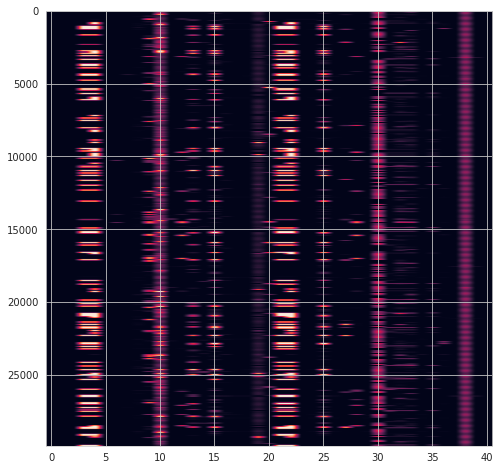

In [ ]:
### Remove columns that have reports missing for a large % of tickers
wrds2 = wrds[wrds.tic.isin(wrdsbydate.columns[columnscovered2])]
allna = (wrds2.groupby('tic').count() == 0).sum(axis = 0)
columns_to_remove = list(set(wrds2.columns[wrds2.isna().mean() > 0.35]) | set(allna[allna > 100].index))
wrds3 = wrds2.drop(columns = columns_to_remove).sort_values(by = ['tic', 'datadate'])

plt.figure(figsize = FigSize)
plt.imshow(wrds3.isna().astype(int),aspect='auto');
print("columns dropped\n", columns_to_remove)
wrds3.head()

#### Ticker analysis of the WRDS dataset. Given a set of columns that are of high quality - exclude the tickers of the lowest quality 

Number of tickers with a full missing info for at least k%  of columns 70
tickers dropped
 Index(['AFL', 'AIG', 'AIV', 'ALL', 'ARE', 'AVB', 'AXP', 'BAC', 'BEN', 'BK',
       'BLK', 'BXP', 'C', 'CB', 'CINF', 'CMA', 'COF', 'DE', 'DHI', 'DRE',
       'EQR', 'ESS', 'FITB', 'FRT', 'GE', 'GL', 'GS', 'HBAN', 'HIG', 'HST',
       'JPM', 'KEY', 'KIM', 'L', 'LEN', 'LNC', 'MAA', 'MS', 'MTB', 'NTRS',
       'NVR', 'O', 'PBCT', 'PCAR', 'PEAK', 'PGR', 'PHM', 'PLD', 'PNC', 'PSA',
       'RE', 'REG', 'RF', 'RJF', 'SCHW', 'SIVB', 'SLG', 'SPG', 'STT', 'TFC',
       'TROW', 'TRV', 'UDR', 'UNM', 'USB', 'VNO', 'WELL', 'WFC', 'WRB',
       'ZION'],
      dtype='object', name='tic')


,datadate,tic,srcq,actq,ancq,atq,ceqq,cheq,cogsq,cshiq,cshopq,cshoq,cstkq,dlcq,dlttq,dpq,epspi12,epspiq,epspxq,intanq,invtq,lctq,lltq,ltq,niq,oibdpq,opepsq,rectq,req,saleq,teqq,capxy,dltisy,dltry,niy,oancfy,txty,dvpspq,mkvaltq,prccq,date
0,19991231,AAPL,5,4909.0,2677.0,7586.0,4264.0,3660.0,1716.0,161.224,NaN,161.224,1345.0,0.0,300.0,20.0,4.230,1.14,1.14,NaN,15.0,1965.0,1207.0,3172.0,183.0,218.0,1.53,892.0,2919.0,2343.0,NaN,38.0,0.0,0.0,183.0,373.0,91.0,0.0,NaN,102.8125,1999-12-31
1,20000331,AAPL,5,4912.0,2095.0,7007.0,4065.0,3609.0,1375.0,162.680,NaN,162.680,1419.0,0.0,300.0,21.0,4.670,1.44,1.44,NaN,10.0,1853.0,939.0,2792.0,233.0,191.0,1.44,940.0,2646.0,1945.0,NaN,65.0,0.0,0.0,416.0,434.0,177.0,0.0,NaN,135.8125,2000-03-31
2,20000630,AAPL,5,5157.0,1775.0,6932.0,4026.0,3826.0,1257.0,324.826,NaN,324.826,1376.0,0.0,300.0,25.0,2.245,0.62,0.62,NaN,5.0,1873.0,883.0,2756.0,200.0,193.0,0.62,967.0,2650.0,1825.0,NaN,76.0,0.0,0.0,616.0,668.0,247.0,0.0,NaN,52.3750,2000-06-30
3,20000930,AAPL,5,5427.0,1376.0,6803.0,4031.0,4027.0,1385.0,335.677,NaN,335.677,1502.0,0.0,300.0,18.0,2.420,0.52,0.52,NaN,33.0,1933.0,763.0,2696.0,170.0,102.0,0.52,953.0,2529.0,1870.0,NaN,107.0,0.0,0.0,786.0,826.0,306.0,0.0,NaN,25.7500,2000-09-30
4,20001231,AAPL,5,4926.0,1060.0,5986.0,3709.0,4065.0,1004.0,345.307,NaN,345.307,1578.0,0.0,311.0,24.0,1.280,-0.58,-0.61,NaN,21.0,1637.0,637.0,2274.0,-195.0,-396.0,-0.61,441.0,2131.0,1007.0,NaN,22.0,0.0,0.0,-195.0,-13.0,-88.0,0.0,NaN,14.8750,2000-12-31


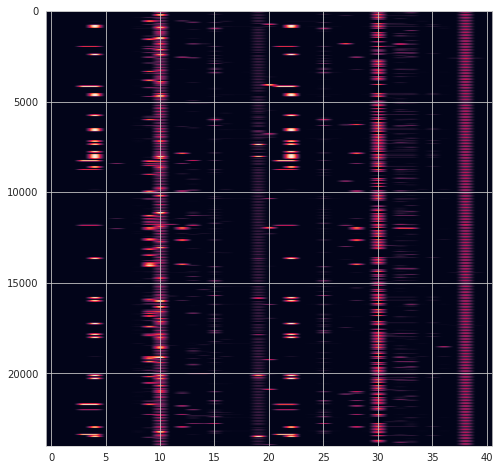

In [ ]:
k = 0.05
AllNaTickers = (wrds3.groupby('tic').count() == 0).mean(axis = 1)
print("Number of tickers with a full missing info for at least k%  of columns", 
      sum(AllNaTickers > k)) 
#drop these tickers as well since they have columns 
#that are all na for columns that have good coverage as per above 
tickers_to_drop = AllNaTickers[AllNaTickers>k].index
wrds4= wrds3[~wrds3.tic.isin(tickers_to_drop)]
plt.figure(figsize = FigSize)
plt.imshow(wrds4.isna().astype(int),aspect='auto');
print("tickers dropped\n", tickers_to_drop)
wrds4.head()

tic
ED       0
NEE      0
DUK      0
LNT      0
NI       0
        ..
CPRT    61
LHX     61
PG      61
CLX     61
ADP     61
Length: 286, dtype: int64

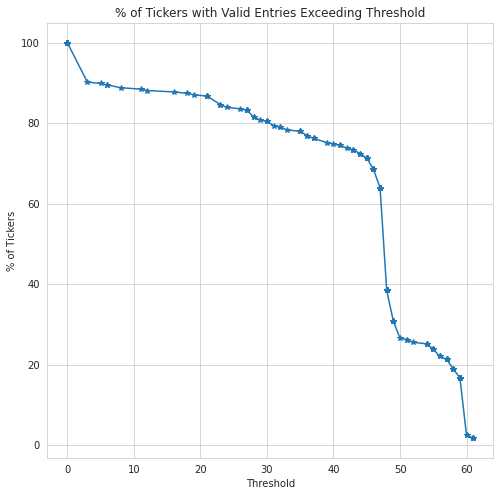

In [ ]:
numvalid_by_tic = wrds4.groupby('tic').count().min(axis=1).sort_values()
#for each date what % of ticker have missing reports? 
cut_offs = np.array([])
stats = np.array([])
for cut in numvalid_by_tic.values:
  cut_offs = np.append(cut_offs, cut)
  stats = np.append(stats, (numvalid_by_tic  >= cut).mean())
plt.figure(figsize = (FigSize))
plt.plot(cut_offs, 100*stats, '-*');
plt.title("% of Tickers with Valid Entries Exceeding Threshold")
plt.xlabel("Threshold")
plt.ylabel("% of Tickers");
numvalid_by_tic

In [ ]:
### KNN for the missing values
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=2, weights="uniform")
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
Y = wrds4.select_dtypes(include=numerics)
wrds_compare = wrds4.copy(deep=True)
imputer.fit_transform(Y.values)
Y_cleaned = imputer.transform(Y.values)

In [ ]:
Y

,datadate,srcq,actq,ancq,atq,ceqq,cheq,cogsq,cshiq,cshopq,cshoq,cstkq,dlcq,dlttq,dpq,epspi12,epspiq,epspxq,intanq,invtq,lctq,lltq,ltq,niq,oibdpq,opepsq,rectq,req,saleq,teqq,capxy,dltisy,dltry,niy,oancfy,txty,dvpspq,mkvaltq,prccq
0,19991231,5,4909.0,2677.0,7586.0,4264.0,3660.0,1716.0,161.224,NaN,161.224,1345.0,0.0,300.0,20.0,4.230,1.14,1.14,NaN,15.0,1965.0,1207.0,3172.0,183.0,218.0,1.53,892.0,2919.0,2343.0,NaN,38.0,0.0,0.0,183.0,373.0,91.0,0.0,NaN,102.8125
1,20000331,5,4912.0,2095.0,7007.0,4065.0,3609.0,1375.0,162.680,NaN,162.680,1419.0,0.0,300.0,21.0,4.670,1.44,1.44,NaN,10.0,1853.0,939.0,2792.0,233.0,191.0,1.44,940.0,2646.0,1945.0,NaN,65.0,0.0,0.0,416.0,434.0,177.0,0.0,NaN,135.8125
2,20000630,5,5157.0,1775.0,6932.0,4026.0,3826.0,1257.0,324.826,NaN,324.826,1376.0,0.0,300.0,25.0,2.245,0.62,0.62,NaN,5.0,1873.0,883.0,2756.0,200.0,193.0,0.62,967.0,2650.0,1825.0,NaN,76.0,0.0,0.0,616.0,668.0,247.0,0.0,NaN,52.3750
3,20000930,5,5427.0,1376.0,6803.0,4031.0,4027.0,1385.0,335.677,NaN,335.677,1502.0,0.0,300.0,18.0,2.420,0.52,0.52,NaN,33.0,1933.0,763.0,2696.0,170.0,102.0,0.52,953.0,2529.0,1870.0,NaN,107.0,0.0,0.0,786.0,826.0,306.0,0.0,NaN,25.7500
4,20001231,5,4926.0,1060.0,5986.0,3709.0,4065.0,1004.0,345.307,NaN,345.307,1578.0,0.0,311.0,24.0,1.280,-0.58,-0.61,NaN,21.0,1637.0,637.0,2274.0,-195.0,-396.0,-0.61,441.0,2131.0,1007.0,NaN,22.0,0.0,0.0,-195.0,-13.0,-88.0,0.0,NaN,14.8750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30007,20190930,5,1231.0,3477.0,4708.0,1694.0,33.0,574.0,72.152,0.101,54.047,1.0,238.0,1419.0,44.0,9.090,2.52,2.52,2908.0,468.0,1306.0,1708.0,3014.0,136.0,244.0,2.84,673.0,2032.0,1130.0,1694.0,44.0,593.0,661.0,375.0,420.0,44.0,0.0,11153.6794,206.3700
30008,20191231,5,1195.0,3516.0,4711.0,1839.0,30.0,631.0,72.152,0.137,54.003,1.0,226.0,1180.0,36.0,10.080,3.13,3.13,2897.0,474.0,1404.0,1468.0,2872.0,169.0,234.0,3.28,645.0,2188.0,1192.0,1839.0,61.0,637.0,949.0,544.0,685.0,54.0,0.0,13794.5263,255.4400
30009,20200331,5,1051.0,3489.0,4540.0,1727.0,24.0,561.0,72.152,0.949,53.066,1.0,230.0,1262.0,34.0,9.590,1.66,1.66,2876.0,443.0,1237.0,1576.0,2813.0,89.0,190.0,1.73,536.0,2270.0,1052.0,1727.0,13.0,157.0,36.0,89.0,108.0,14.0,0.0,9742.9176,183.6000
30010,20200630,5,1094.0,3513.0,4607.0,1803.0,86.0,519.0,72.152,0.000,53.323,1.0,233.0,1091.0,34.0,9.180,1.87,1.87,2863.0,513.0,1389.0,1415.0,2804.0,100.0,156.0,1.92,458.0,2363.0,956.0,1803.0,33.0,24.0,84.0,189.0,355.0,17.0,0.0,13648.0219,255.9500


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:6397: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


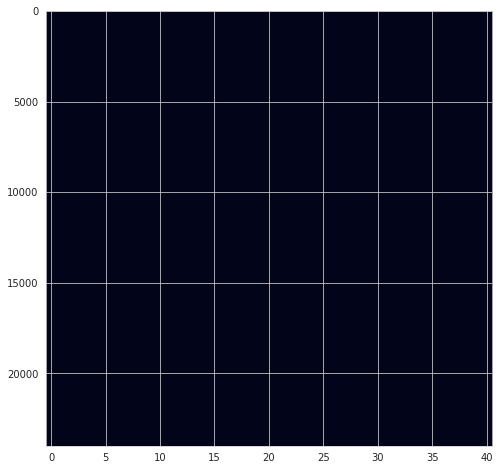

In [ ]:
Y.loc[:,:] = Y_cleaned
wrds4.update(Y)
plt.figure(figsize = FigSize)
plt.imshow(wrds4.isna().astype(int),aspect='auto');

In [ ]:
y4 = wrds4.select_dtypes(include=numerics)
ycompare = wrds_compare.select_dtypes(include=numerics)
diff = y4 - ycompare
diff[(~(y4 == ycompare)).any(axis = 1)]

,datadate,srcq,actq,ancq,atq,ceqq,cheq,cogsq,cshiq,cshopq,cshoq,cstkq,dlcq,dlttq,dpq,epspi12,epspiq,epspxq,intanq,invtq,lctq,lltq,ltq,niq,oibdpq,opepsq,rectq,req,saleq,teqq,capxy,dltisy,dltry,niy,oancfy,txty,dvpspq,mkvaltq,prccq
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29953,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29954,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29955,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29958,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


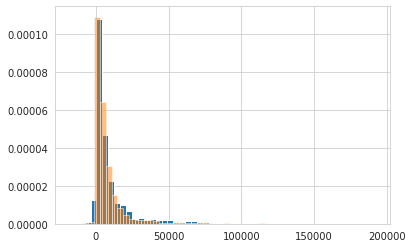

In [ ]:
UpdatedRows = (~(y4 == ycompare)).any(axis = 1)
UpdatedColumns = y4.columns[(~(y4 == ycompare)).any(axis = 0)]
#y4[UpdatedRows][UpdatedColumns].hist(figsize = (16,20));
#y4[~UpdatedRows][UpdatedColumns].hist(figsize = (16,20));
y4[~UpdatedRows]['ceqq'].hist(density = True, bins = 50, alpha=1);
y4[UpdatedRows]['ceqq'].hist(density = True, bins = 50, alpha = 0.5);

Boyd's Paper drops the series that do not contain continuous observations

paper ctrl-f 'S&P' for details https://stanford.edu/~boyd/papers/pdf/cvx_portfolio.pdf 

Furthermore, to estimate the period return covariance matrix the log returns will be used to get daily  means and covariance matrices, then scaled to the desired time horizon and then transformed back to linear return estimates

In [ ]:
cut_dt

Timestamp('2000-02-29 00:00:00')

In [ ]:
logret = np.log1p(P.loc[:,P.columns[P.columns.isin(wrds4.tic.unique())]].pct_change()).dropna()
Prices = P.loc[:,P.columns[P.columns.isin(wrds4.tic.unique())]]
Prices.to_pickle("cache/Daily_Prices.pkl")

### Calculate the exponentially weighted averages and Forecasts

In [ ]:
from pandas.tseries.offsets import MonthEnd, Day, MonthBegin

dates = pd.DataFrame(logret.index[logret.index >= cut_dt + MonthBegin(1)])
dates['Month'] = dates.Date.dt.month
#dates['Month'] = dates.Date.dt.month
dates['Year'] = dates.Date.dt.year

decision_dates = dates.groupby(by = ['Year','Month']).agg({'Date':'min', 'Year':'count'}).rename(columns={'Date':'Date', 'Year': 'ActualDays'})
decision_dates['MonthStart'] = decision_dates.Date +Day(1) + MonthBegin(-1)
decision_dates['MonthEnd'] = decision_dates.Date  + MonthBegin(1)

print(decision_dates)

                 Date  ActualDays MonthStart   MonthEnd
Year Month                                             
2000 3     2000-03-01          23 2000-03-01 2000-04-01
     4     2000-04-03          19 2000-04-01 2000-05-01
     5     2000-05-01          22 2000-05-01 2000-06-01
     6     2000-06-01          22 2000-06-01 2000-07-01
     7     2000-07-03          20 2000-07-01 2000-08-01
...               ...         ...        ...        ...
2020 6     2020-06-01          22 2020-06-01 2020-07-01
     7     2020-07-01          22 2020-07-01 2020-08-01
     8     2020-08-03          21 2020-08-01 2020-09-01
     9     2020-09-01          21 2020-09-01 2020-10-01
     10    2020-10-01          22 2020-10-01 2020-11-01

[248 rows x 4 columns]


In [ ]:
#as of the first business day, append on the expected number of trading days in the month
from pandas.tseries.holiday import AbstractHolidayCalendar, Holiday, nearest_workday, \
    USMartinLutherKingJr, USPresidentsDay, GoodFriday, USMemorialDay, \
    USLaborDay, USThanksgivingDay

class USTradingCalendar(AbstractHolidayCalendar):
    rules = [
        Holiday('NewYearsDay', month=1, day=1, observance=nearest_workday),
        USMartinLutherKingJr,
        USPresidentsDay,
        GoodFriday,
        USMemorialDay,
        Holiday('USIndependenceDay', month=7, day=4, observance=nearest_workday),
        USLaborDay,
        USThanksgivingDay,
        Holiday('Christmas', month=12, day=25, observance=nearest_workday)
    ]

calendar = USTradingCalendar()

holidays = calendar.holidays(np.min(decision_dates.Date), np.max(decision_dates.MonthEnd))
holiday_date_list = holidays.date.tolist()
decision_dates["ExpectedDays"] = np.busday_count(decision_dates.MonthStart.values.astype('datetime64[D]'), 
                                                 decision_dates.MonthEnd.values.astype('datetime64[D]'), 
                                                 holidays = holiday_date_list)
decision_dates
decision_dates[decision_dates.ActualDays != decision_dates.ExpectedDays]

Date  ActualDays MonthStart   MonthEnd  ExpectedDays
Year Month                                                           
2001 9     2001-09-04          15 2001-09-01 2001-10-01            19
2004 6     2004-06-01          21 2004-06-01 2004-07-01            22
     12    2004-12-01          22 2004-12-01 2005-01-01            21
2007 1     2007-01-03          20 2007-01-01 2007-02-01            21
2010 12    2010-12-01          22 2010-12-01 2011-01-01            21
2012 10    2012-10-01          21 2012-10-01 2012-11-01            23
2018 12    2018-12-03          19 2018-12-01 2019-01-01            20

Year  Month
2001  9       -4
2012  10      -2
2018  12      -1
2004  6       -1
2007  1       -1
              ..
      10       0
2006  9        0
2020  10       0
2004  12       1
2010  12       1
Length: 248, dtype: int64

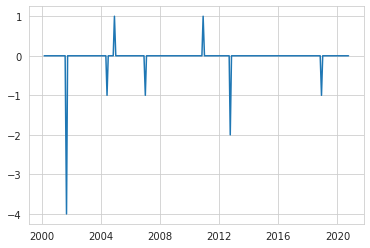

In [ ]:
diff = (decision_dates.ActualDays - decision_dates.ExpectedDays);
plt.plot(decision_dates.Date, (decision_dates.ActualDays - decision_dates.ExpectedDays));
#2001 9 is missing 4 days due to 911 
#2012 10 is missing 2 days due to Katrina
#2004 6 is missing a day due to Ronald Reagans funeral
#2018 12 is missing a day due to George W. Bush funeral
#2010 and 2004 both have December 31st as a trading day. Even though
#the logic dictates that they should be a holiday. This info was likely known
# at trade time
# From this is it safe to conclude that the expected number of trading days in the month 
# is equal to the max of the two columns.
decision_dates['ExpectedDaysCorr'] = decision_dates['ExpectedDays']
diff.sort_values()

In [ ]:
#logret.AAPL.dropna().plot()
lambd = 0.985 #from risk metrics, but Litterman recommends 0.98 for monthly returns estimation
lambd_factor = 0.94 #short term mean for factor 
EW_ret = logret.ewm(alpha=1-lambd).mean().dropna()

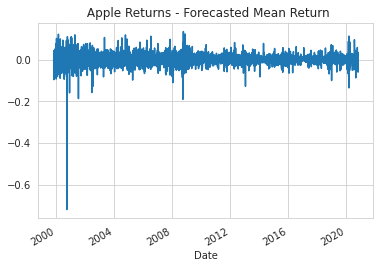

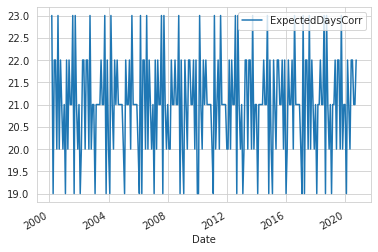

In [ ]:
(logret.AAPL - logret.AAPL.ewm(alpha=1-0.985).mean()).dropna().plot(title = ' Apple Returns - Forecasted Mean Return');
(logret.AAPL - logret.AAPL.ewm(alpha=1-0.985).mean()).sort_values() #September 29th 2000 was an interesting day for apple
decision_dates.plot(x = 'Date', y = 'ExpectedDaysCorr');

We need to project the distribution of the invariants to the investment horizon and then compute the quantities of interest E{Rτ} and Cov {Rτ}. Only when the market is not too volatile and both the investment horizon and the estimation interval are short is when the returns are iid and the projection can be done by simple scaling. 

However, short estimation and investment periods lead to estimation uncertainty as well. This trade off is not investigated in this work. The experiments performed here consider monthly estimation of covariances and mean 

In [ ]:
### exponential weighted mean and covariance function
def eqma(df, alpha):
  weights = (1- alpha) ** np.arange(len(df))[::-1]
  normalized = (df - df.mean()).fillna(0).to_numpy()
  cov = ((weights *normalized.T))@normalized/weights.sum()
  mean = (df.multiply(weights, axis=0).values).sum(axis=0)/(weights.sum())
  
  return cov, mean

#plt.figure(figsize=(10,10))
#plt.matshow(eqma(logret, 1-0.985), fignum=1);
cov, mean = eqma(logret, 1-0.985)

In [ ]:
# the covariance matrices are close
c1,m1 = eqma(logret['1999-11-02':'2000-03-01	'], 1-0.985)
c2,m2 = eqma(logret['1999-12-01':'2000-03-01'], 1-0.985)
(np.mean((c2 - c1)**2))**0.5
100*np.max(np.abs(m1-m2)) #such a small difference

0.5423995579966229

In [ ]:
decision_dates.Date

Year  Month
2000  3       2000-03-01
      4       2000-04-03
      5       2000-05-01
      6       2000-06-01
      7       2000-07-03
                 ...    
2020  6       2020-06-01
      7       2020-07-01
      8       2020-08-03
      9       2020-09-01
      10      2020-10-01
Name: Date, Length: 248, dtype: datetime64[ns]

In [ ]:
#for each month, estimate the exponentially weighted covariance matrix of the linear
#returns that follow from the log returns via the log-normal transformation
forecasts_ew = {}
factors = {}

def fill_dict(forecasts_ew, lambd, fillmean = True):
  for date in decision_dates.Date:
    cov_1day, mean_1day = eqma(logret[logret.index < date], 1-lambd)
    idx = decision_dates.Date == date
    k = decision_dates[idx].ExpectedDays.values[0] #this is one to one
    cov = k*cov_1day
    mean = k*mean_1day
    mean_ = np.expand_dims(mean,axis=1)
    cov_ii = np.expand_dims(np.diag(cov), axis = 1)
    #convert to linear returns
    logmean = np.expand_dims(np.e**(mean + np.diag(cov)/2), axis = 1) - 1
    NbyN = (len(mean),len(mean))
    means_added =  mean_*np.ones( NbyN )  + mean_.transpose()*np.ones( NbyN )
    covdiags_added = (1/2)*(cov_ii*np.ones( NbyN )) + (1/2)*(cov_ii.transpose()*np.ones( NbyN ))
    logcov = (  np.e**(means_added + covdiags_added)  )*( np.e**(cov) - 1)
    start_dt = decision_dates[decision_dates.Date == date].MonthStart.iloc[0]
    forecasts_ew[start_dt] = (logcov, logmean) #estimate the covariance based on data that was available before the trade date
  return 
fill_dict(forecasts_ew, lambd)
#fill_dict(factors, lambd_factor)

with open("cache/Forecasts.pkl", 'wb') as fp:
  pkl.dump(forecasts_ew, fp);

with open("cache/Factors.pkl", 'wb') as fp:
  pkl.dump(factors, fp);

In [ ]:
try:
  del wrds
  del wrds2
  del wrds3
  del y4
  del diff
  del Y
  del Y_cleaned
except:
  print("deleted")

deleted



### Join the wrds info to the decision dates and calculate features

Full outer join on the report dates and the decision dates then filter to report date < decision date and take the most recent report date


In [ ]:
q = """select a.*, b.*  from 
  decision_dates a 
  left join wrds4 b 
  on b.date < a.Date;"""
wrds_asof = sqldf(q, locals())
wrds_asof.to_csv('cache/WRDS_ASOF_UNFILTERED.csv')
wrds4.to_csv('cache/WRDS_PROCESSED.csv')


In [ ]:
wrds_asof = pd.read_csv('cache/WRDS_ASOF_UNFILTERED.csv').iloc[:,1:]
wrds_asof.MonthStart = pd.to_datetime(wrds_asof.MonthStart)

In [ ]:
wrds_asof_uniq = wrds_asof.sort_values('date', ascending=False).groupby(['MonthStart', 'tic']).first()
#del wrds_asof
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
wrds_asof_diff = wrds_asof.sort_values('date', ascending=False).groupby(['MonthStart', 'tic']).head(2).sort_values(by = ['MonthStart', 'tic','date'])
wrds_asof_pct = (wrds_asof_diff.groupby(['MonthStart', 'tic']).first().select_dtypes(include=numerics) - 
                 wrds_asof_diff.groupby(['MonthStart', 'tic']).last().select_dtypes(include=numerics))/ \
                 (np.abs(wrds_asof_diff.groupby(['MonthStart', 'tic']).last().select_dtypes(include=numerics))
                 + np.abs(wrds_asof_diff.groupby(['MonthStart', 'tic']).first().select_dtypes(include=numerics)+0.001)
                 )
col_map = {col: "DIFF" + col for col in wrds_asof_pct}
wrds_asof_pct.rename(columns = col_map, inplace = True)

In [ ]:
wrds_asof_uniq.index

MultiIndex([('2000-03-01', 'AAPL'),
            ('2000-03-01',  'ABC'),
            ('2000-03-01', 'ABMD'),
            ('2000-03-01',  'ABT'),
            ('2000-03-01', 'ADBE'),
            ('2000-03-01',  'ADI'),
            ('2000-03-01',  'ADM'),
            ('2000-03-01',  'ADP'),
            ('2000-03-01', 'ADSK'),
            ('2000-03-01',  'AEE'),
            ...
            ('2020-10-01',  'WMB'),
            ('2020-10-01',  'WMT'),
            ('2020-10-01',   'WY'),
            ('2020-10-01',  'XEL'),
            ('2020-10-01', 'XLNX'),
            ('2020-10-01',  'XOM'),
            ('2020-10-01', 'XRAY'),
            ('2020-10-01',  'XRX'),
            ('2020-10-01',  'YUM'),
            ('2020-10-01', 'ZBRA')],
           names=['MonthStart', 'tic'], length=70928)

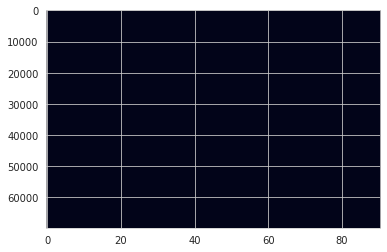

In [ ]:
diff_filter = wrds_asof_diff.groupby(['MonthStart', 'tic']).datadate.count() == 2 #(for each ticker there needs to be two reports to calculate the change)
validmonths = diff_filter.groupby('MonthStart').sum() == np.max(diff_filter.groupby('MonthStart').sum())
new_cut_off = validmonths[validmonths].index[0] #get first valid date to cut off later
wrds_svm = pd.merge(wrds_asof_uniq[new_cut_off:], wrds_asof_pct[new_cut_off:], left_index=True, right_index= True)
plt.imshow(wrds_svm.isna().astype(int),aspect='auto');

In [ ]:
###Calculate Columns as per "Stock Selection using Support Vector Machines" Paper

#RETURN ON CAPITAL
wrds_svm['ROC1'] =  (wrds_svm.txty+wrds_svm.req)/wrds_svm.atq
#wrds_svm['ROC1'].hist(bins=30);

#TEQQ shareholder equity add in
wrds_svm['ROC2'] = (wrds_svm.txty+wrds_svm.req)/(wrds_svm.dlttq+ wrds_svm.teqq)
#wrds_svm['ROC2'].hist(bins=30);

#TEQQ shareholder equity add in
wrds_svm['ROC3'] =  wrds_svm.niq/(wrds_svm.dlttq+ wrds_svm.teqq)
#wrds_svm['ROC3'].hist(bins=30);

wrds_svm['ROC4'] =  wrds_svm.oancfy/wrds_svm.atq
#wrds_svm['ROC4'].hist(bins=30);

#TEQQ shareholder equity add in
wrds_svm['ROC5'] =  wrds_svm.oancfy/(wrds_svm.dlttq+ wrds_svm.teqq)
#wrds_svm['ROC5'].hist(bins=30);

#INVESTMENTS
#eps is assumed to be .1 cents per share
wrds_svm['INV1'] =  wrds_svm.prccq/(wrds_svm.epspxq+0.001) 
#wrds_svm['INV1'].hist(bins=50);

wrds_svm['INV2'] =  wrds_svm.dvpspq/wrds_svm.prccq
#wrds_svm['INV2'].hist(bins=50);

wrds_svm['INV3'] =  wrds_svm.teqq/(wrds_svm.prccq*wrds_svm.cshoq)
#wrds_svm['INV3'].hist(bins=50);

#PROFIT
wrds_svm['PRO1'] =  (wrds_svm.txty+wrds_svm.req)/(wrds_svm.saleq)
#wrds_svm['PRO1'].hist(bins=50);

wrds_svm['PRO2'] =  (wrds_svm.req)/(wrds_svm.saleq)
#wrds_svm['PRO2'].hist(bins=50);

wrds_svm['PRO3'] =  (wrds_svm.niq)/(wrds_svm.saleq)
#wrds_svm['PRO3'].hist(bins=50);

wrds_svm['PRO4'] =  (wrds_svm.oancfy)/(wrds_svm.saleq)
#wrds_svm['PRO4'].hist(bins=50);

wrds_svm['PRO5'] =  (wrds_svm.req)/(wrds_svm.ceqq)
#wrds_svm['PRO5'].hist(bins=50);

wrds_svm['PRO6'] =  (wrds_svm.oancfy)/(wrds_svm.prccq*wrds_svm.cshoq)
#wrds_svm['PRO6'].hist(bins=50);

#add 1M to the operating cashflow
wrds_svm['PRO7'] =  (wrds_svm.req)/(wrds_svm.oancfy+1)
#wrds_svm['PRO7'].hist(bins=50);

wrds_svm['LEV1'] =  (wrds_svm.dlttq)/(wrds_svm.teqq)
#wrds_svm['LEV1'].hist(bins=50);

wrds_svm['LEV2'] =  (wrds_svm.lltq+ wrds_svm.lctq)/(wrds_svm.dlttq+ wrds_svm.teqq)
#wrds_svm['LEV2'].hist(bins=50);

wrds_svm['LEV3'] =  (wrds_svm.lltq + wrds_svm.lctq)/(wrds_svm.teqq)
#wrds_svm['LEV3'].hist(bins=50);

wrds_svm['LEV4'] =  (wrds_svm.atq)/(wrds_svm.teqq)
#wrds_svm['LEV4'].hist(bins=50);

wrds_svm['LEV5'] =  (wrds_svm.atq)/(wrds_svm.prccq*wrds_svm.cshoq)
#wrds_svm['LEV5'].hist(bins=50);

wrds_svm['RET1'] =  (wrds_svm.niq)/(wrds_svm.atq)
#wrds_svm['RET1'].hist(bins=50);

wrds_svm['LIQ1'] =  (wrds_svm.actq)/(wrds_svm.lctq)
#wrds_svm['LIQ1'].hist(bins=50);

wrds_svm['LIQ2'] =  (wrds_svm.lctq)/(wrds_svm.atq)
#wrds_svm['LIQ2'].hist(bins=50);

wrds_svm['LIQ3'] =  (wrds_svm.lctq)/(wrds_svm.teqq)
#wrds_svm['LIQ3'].hist(bins=50);

wrds_svm['LIQ4'] =  (wrds_svm.dlttq)/(wrds_svm.lltq + wrds_svm.lctq)
#wrds_svm['LIQ4'].hist(bins=50);

wrds_svm['LIQ5'] =  (wrds_svm.cheq)/(wrds_svm.lctq)
#wrds_svm['LIQ4'].hist(bins=50);

wrds_svm['RISK1'] =  (wrds_svm.txty + wrds_svm.req)/(wrds_svm.lctq)
#wrds_svm['RISK1'].hist(bins=50);

wrds_svm['RISK2'] =  (wrds_svm.req)/(wrds_svm.lctq)
#wrds_svm['RISK2'].hist(bins=50);

wrds_svm['RISK3'] =  (wrds_svm.oancfy)/(wrds_svm.lctq)
#wrds_svm['RISK3'].hist(bins=50);

#Growth Metrics 
wrds_svm['GRW1'] =  (wrds_svm.DIFFatq)

wrds_svm['GRW2'] =  (wrds_svm.DIFFsaleq)

wrds_svm['GRW3'] =  (wrds_svm.DIFFreq)

wrds_svm['GRW4'] =  (wrds_svm.DIFFepspxq)

wrds_svm['GRW5'] =  (wrds_svm.DIFFoancfy)

wrds_svm['GRW6'] =  (wrds_svm.DIFFteqq)

wrds_svm['GRW7'] =  (wrds_svm.DIFFcapxy)

wrds_svm['GRW8'] =  (wrds_svm.DIFFrectq)

In [ ]:
#add in the momentum index for the SVM attributes
momentum = []
momentum_index = []
dts = wrds_svm.index.get_level_values('MonthStart').unique()
for dt, forecast in forecasts_ew.items():
  if dt in dts:
    momentum += forecast[1].flatten().tolist()
    momentum_index += [dt for i in range(len(forecast[1].flatten()))]
momentum = pd.Series(data = momentum, index = momentum_index).sort_index()
wrds_svm['Momentum'] = momentum.values

#add in the vol index for the SVM attributes
vol = []
vol_index = []
dts = wrds_svm.index.get_level_values('MonthStart').unique()
for dt, forecast in forecasts_ew.items():
  if dt in dts:
    vol += np.diag(forecast[0]).tolist()
    vol_index += [dt for i in range(len(np.diag(forecast[0])))]
vol = pd.Series(data = vol, index = vol_index).sort_index()
wrds_svm['Vol'] = vol.values

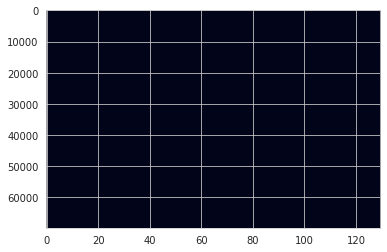

In [ ]:
plt.imshow((wrds_svm == np.inf).astype(int),aspect='auto');

Year  Month  ...  Momentum       Vol
MonthStart tic                ...                    
2000-07-01 AAPL  2000      7  ...  0.022558  0.040999
           ABC   2000      7  ...  0.190470  0.056325
           ABMD  2000      7  ... -0.034639  0.071497
           ABT   2000      7  ...  0.059950  0.014319
           ADBE  2000      7  ...  0.125271  0.081889

[5 rows x 130 columns]

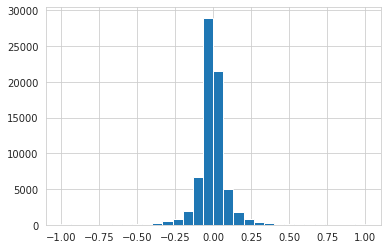

In [ ]:
wrds_svm['DIFFrectq'].hist(bins=30);
wrds_svm.head()

### Calculate the monthly returns of the stocks 

In [ ]:
StockDates = wrds_svm.reset_index().loc[:, ['Date', 'MonthStart', 'MonthEnd']].drop_duplicates()

In [ ]:
#buy stock on day 1 of month 
#observe return one month later
Prices['StartMonth'] = Prices.index + Day(1) + MonthBegin(-1) 
Rets = Prices.sort_index().groupby('StartMonth').first().pct_change()
#Prices.sort_index().groupby('Month').last()
# Prices['EndMonth'] = Prices.index + MonthBegin(1) 
# Prices.loc[:, ['StartMonth',  'EndMonth']].head(40)
new_index = Rets.index[0:-1] #VERY IMPORTANT
Rets.drop(Rets.head(1).index,inplace=True)
Rets.index = new_index
Rets

,AAPL,ABC,ABMD,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,AEP,AES,AJG,AKAM,ALB,ALK,AMAT,AMD,AME,AMGN,AMT,AMZN,ANSS,AON,AOS,APA,APD,APH,ATO,AVY,AZO,BA,BAX,BBY,BDX,BKNG,BLL,BMY,BSX,BWA,...,SYK,SYY,T,TAP,TFX,TGT,TJX,TMO,TSCO,TSN,TT,TXN,TXT,UHS,UNH,UNP,URI,VFC,VLO,VMC,VRSN,VRTX,VZ,WAB,WAT,WBA,WDC,WEC,WHR,WM,WMB,WMT,WY,XEL,XLNX,XOM,XRAY,XRX,YUM,ZBRA
StartMonth,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1999-11-01,0.327698,-0.091324,0.500000,-0.071318,-0.029171,0.076752,0.014558,0.010404,0.578595,-0.094059,-0.079630,0.028825,0.070646,0.248476,-0.026144,-0.049679,0.145299,0.353846,-0.009375,0.103502,0.399340,0.229656,0.048611,0.029332,-0.144279,-0.087637,0.149220,0.142857,-0.020267,-0.030481,0.051643,-0.067073,0.065493,0.289696,0.071429,0.036325,-0.053962,-0.066343,0.002994,0.021944,...,-0.068068,-0.008064,-0.016510,-0.073015,-0.011130,0.092260,-0.106238,0.137615,-0.156250,0.113639,-0.067729,0.140805,-0.015307,0.095634,0.011976,-0.137414,-0.047468,0.008179,0.144816,-0.049858,0.390974,0.011820,0.000000,-0.029633,-0.025958,0.151867,0.220000,-0.106172,-0.135198,-0.140000,-0.123967,0.041390,-0.035070,-0.065903,0.135714,0.110253,0.027396,-0.029271,0.003082,0.008475
1999-12-01,0.086113,0.251256,0.186992,-0.065109,-0.014655,0.490703,-0.010309,0.072631,0.131356,-0.040630,0.000000,0.250000,0.165375,0.476163,-0.028139,-0.055649,0.258707,0.127273,-0.038123,0.420310,0.106132,0.051471,0.172185,0.094257,0.008721,-0.061612,0.023001,-0.011029,-0.098315,0.213603,0.091518,-0.031626,-0.094987,-0.131579,-0.033332,-0.154639,0.054635,-0.106586,0.098507,-0.050614,...,0.177238,-0.008130,-0.098321,0.009963,-0.070631,0.039675,-0.149214,-0.032258,-0.059259,-0.082143,0.118734,0.036524,0.040101,0.130930,0.017751,-0.073681,-0.112957,-0.031422,-0.083832,0.001589,1.077869,0.404206,-0.069835,-0.048443,0.045685,-0.004357,0.032787,-0.037855,0.011247,0.077519,-0.059708,0.141421,0.160955,-0.050191,0.045423,-0.050758,0.005006,-0.087264,-0.082949,-0.053571
2000-01-01,-0.104411,0.200804,0.575342,-0.056097,-0.147760,0.086625,0.000000,-0.073317,-0.048735,0.007737,0.071571,0.113794,-0.142436,-0.255837,-0.024306,-0.092857,0.110672,0.179435,0.039474,0.037736,0.321961,-0.245455,-0.039548,-0.325320,-0.098580,0.111722,-0.066666,0.002788,-0.115265,-0.060420,-0.139059,0.088647,0.028513,-0.139610,0.035800,0.117073,-0.097331,0.007052,-0.114130,-0.157916,...,-0.056673,-0.072396,-0.093482,-0.040690,-0.002001,-0.064180,-0.181538,0.179167,0.110236,-0.136187,-0.130897,0.100056,-0.199333,0.209731,0.012791,-0.063861,0.183521,-0.118143,0.192810,0.074604,-0.108810,0.054077,0.000167,-0.352727,0.455097,0.008753,0.190476,0.042623,-0.034378,0.007194,0.225806,-0.121608,-0.175009,0.013158,0.025400,0.062251,0.063830,-0.139535,-0.175880,0.057714
2000-02-01,0.299875,-0.204013,0.169565,0.028518,0.796421,0.647959,-0.137029,-0.081712,0.414202,-0.094050,-0.166981,0.014705,-0.079038,0.165490,-0.170819,-0.159449,0.314057,0.107692,-0.063291,-0.003828,0.261290,-0.023170,0.235294,-0.116724,-0.141479,-0.054366,-0.153061,0.267840,-0.054147,-0.120977,-0.140143,-0.167157,-0.111881,0.106918,0.154378,0.124454,-0.248182,-0.206963,-0.121166,0.001927,...,-0.147287,-0.060284,-0.008849,-0.101907,-0.051749,-0.120032,-0.005494,-0.024735,0.070922,-0.235944,-0.175617,0.453039,-0.014584,-0.110958,0.003444,-0.051163,-0.215190,-0.045455,0.160156,-0.043993,0.482110,1.085241,-0.077649,-0.122901,0.294412,-0.109567,0.000000,-0.108455,-0.099066,-0.157143,0.175987,-0.165069,-0.066594,-0.107143,0.558018,-0.080525,0.032501,0.045651,-0.083333,0.124869
2000-03-01,0.023022,-0.016807,-0.431227,0.094270,0.051939,-0.081269,0.018182,0.132234,-0.018131,0.079401,0.081632,-0.049581,0.313553,-0.572903,0.382899,0.086651,-0.033175,0.503086,0.068195,-0.087416,-0.076726,-0.035104,-0.223810,0.368564,0.101124,0.364525,0.168844,0.177632,-0.018939,0.012779,0.232044,0.024097,0.159432,0.507954,-0.135009,0.015534,0.316279,0.203658,0.155323,0.167308,...,0.272727,0.103774,0.065477,0.132184,0.148620,0.299578,0.443182,0.159420,0.086092,-

In [ ]:
Rets

,AAPL,ABC,ABMD,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,AEP,AES,AJG,AKAM,ALB,ALK,AMAT,AMD,AME,AMGN,AMT,AMZN,ANSS,AON,AOS,APA,APD,APH,ATO,AVY,AZO,BA,BAX,BBY,BDX,BKNG,BLL,BMY,BSX,BWA,...,SYK,SYY,T,TAP,TFX,TGT,TJX,TMO,TSCO,TSN,TT,TXN,TXT,UHS,UNH,UNP,URI,VFC,VLO,VMC,VRSN,VRTX,VZ,WAB,WAT,WBA,WDC,WEC,WHR,WM,WMB,WMT,WY,XEL,XLNX,XOM,XRAY,XRX,YUM,ZBRA
StartMonth,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1999-11-01,0.327698,-0.091324,0.500000,-0.071318,-0.029171,0.076752,0.014558,0.010404,0.578595,-0.094059,-0.079630,0.028825,0.070646,0.248476,-0.026144,-0.049679,0.145299,0.353846,-0.009375,0.103502,0.399340,0.229656,0.048611,0.029332,-0.144279,-0.087637,0.149220,0.142857,-0.020267,-0.030481,0.051643,-0.067073,0.065493,0.289696,0.071429,0.036325,-0.053962,-0.066343,0.002994,0.021944,...,-0.068068,-0.008064,-0.016510,-0.073015,-0.011130,0.092260,-0.106238,0.137615,-0.156250,0.113639,-0.067729,0.140805,-0.015307,0.095634,0.011976,-0.137414,-0.047468,0.008179,0.144816,-0.049858,0.390974,0.011820,0.000000,-0.029633,-0.025958,0.151867,0.220000,-0.106172,-0.135198,-0.140000,-0.123967,0.041390,-0.035070,-0.065903,0.135714,0.110253,0.027396,-0.029271,0.003082,0.008475
1999-12-01,0.086113,0.251256,0.186992,-0.065109,-0.014655,0.490703,-0.010309,0.072631,0.131356,-0.040630,0.000000,0.250000,0.165375,0.476163,-0.028139,-0.055649,0.258707,0.127273,-0.038123,0.420310,0.106132,0.051471,0.172185,0.094257,0.008721,-0.061612,0.023001,-0.011029,-0.098315,0.213603,0.091518,-0.031626,-0.094987,-0.131579,-0.033332,-0.154639,0.054635,-0.106586,0.098507,-0.050614,...,0.177238,-0.008130,-0.098321,0.009963,-0.070631,0.039675,-0.149214,-0.032258,-0.059259,-0.082143,0.118734,0.036524,0.040101,0.130930,0.017751,-0.073681,-0.112957,-0.031422,-0.083832,0.001589,1.077869,0.404206,-0.069835,-0.048443,0.045685,-0.004357,0.032787,-0.037855,0.011247,0.077519,-0.059708,0.141421,0.160955,-0.050191,0.045423,-0.050758,0.005006,-0.087264,-0.082949,-0.053571
2000-01-01,-0.104411,0.200804,0.575342,-0.056097,-0.147760,0.086625,0.000000,-0.073317,-0.048735,0.007737,0.071571,0.113794,-0.142436,-0.255837,-0.024306,-0.092857,0.110672,0.179435,0.039474,0.037736,0.321961,-0.245455,-0.039548,-0.325320,-0.098580,0.111722,-0.066666,0.002788,-0.115265,-0.060420,-0.139059,0.088647,0.028513,-0.139610,0.035800,0.117073,-0.097331,0.007052,-0.114130,-0.157916,...,-0.056673,-0.072396,-0.093482,-0.040690,-0.002001,-0.064180,-0.181538,0.179167,0.110236,-0.136187,-0.130897,0.100056,-0.199333,0.209731,0.012791,-0.063861,0.183521,-0.118143,0.192810,0.074604,-0.108810,0.054077,0.000167,-0.352727,0.455097,0.008753,0.190476,0.042623,-0.034378,0.007194,0.225806,-0.121608,-0.175009,0.013158,0.025400,0.062251,0.063830,-0.139535,-0.175880,0.057714
2000-02-01,0.299875,-0.204013,0.169565,0.028518,0.796421,0.647959,-0.137029,-0.081712,0.414202,-0.094050,-0.166981,0.014705,-0.079038,0.165490,-0.170819,-0.159449,0.314057,0.107692,-0.063291,-0.003828,0.261290,-0.023170,0.235294,-0.116724,-0.141479,-0.054366,-0.153061,0.267840,-0.054147,-0.120977,-0.140143,-0.167157,-0.111881,0.106918,0.154378,0.124454,-0.248182,-0.206963,-0.121166,0.001927,...,-0.147287,-0.060284,-0.008849,-0.101907,-0.051749,-0.120032,-0.005494,-0.024735,0.070922,-0.235944,-0.175617,0.453039,-0.014584,-0.110958,0.003444,-0.051163,-0.215190,-0.045455,0.160156,-0.043993,0.482110,1.085241,-0.077649,-0.122901,0.294412,-0.109567,0.000000,-0.108455,-0.099066,-0.157143,0.175987,-0.165069,-0.066594,-0.107143,0.558018,-0.080525,0.032501,0.045651,-0.083333,0.124869
2000-03-01,0.023022,-0.016807,-0.431227,0.094270,0.051939,-0.081269,0.018182,0.132234,-0.018131,0.079401,0.081632,-0.049581,0.313553,-0.572903,0.382899,0.086651,-0.033175,0.503086,0.068195,-0.087416,-0.076726,-0.035104,-0.223810,0.368564,0.101124,0.364525,0.168844,0.177632,-0.018939,0.012779,0.232044,0.024097,0.159432,0.507954,-0.135009,0.015534,0.316279,0.203658,0.155323,0.167308,...,0.272727,0.103774,0.065477,0.132184,0.148620,0.299578,0.443182,0.159420,0.086092,-

In [ ]:
Prices.groupby('StartMonth').std()

,AAPL,ABC,ABMD,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,AEP,AES,AJG,AKAM,ALB,ALK,AMAT,AMD,AME,AMGN,AMT,AMZN,ANSS,AON,AOS,APA,APD,APH,ATO,AVY,AZO,BA,BAX,BBY,BDX,BKNG,BLL,BMY,BSX,BWA,...,SYK,SYY,T,TAP,TFX,TGT,TJX,TMO,TSCO,TSN,TT,TXN,TXT,UHS,UNH,UNP,URI,VFC,VLO,VMC,VRSN,VRTX,VZ,WAB,WAT,WBA,WDC,WEC,WHR,WM,WMB,WMT,WY,XEL,XLNX,XOM,XRAY,XRX,YUM,ZBRA
StartMonth,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1999-11-01,0.040524,0.097611,1.933436,0.258680,0.706511,0.769397,0.408809,0.595106,0.851438,0.478864,0.438170,0.689489,0.155618,16.996207,0.123077,0.221583,1.151382,1.595268,0.035494,2.336305,2.335731,8.289802,0.033737,1.230270,0.158163,0.716145,1.418146,0.086976,0.083480,0.669102,0.923084,0.833997,0.338219,1.343215,0.892729,37.611450,0.044815,0.494205,0.349193,0.084742,...,0.512083,0.200670,0.210435,0.576780,0.778457,0.966256,0.120512,0.355611,0.061437,0.470652,0.376861,1.506065,0.734787,0.367169,0.199621,0.356160,1.319757,0.110428,0.229073,0.782435,7.002479,0.372468,0.306808,0.295624,0.873732,1.222726,0.361335,0.240993,1.664362,0.627375,0.452851,0.828644,0.259464,0.235315,1.425083,0.776284,0.123852,2.237566,0.214422,1.091126
1999-12-01,0.049307,0.219630,3.696857,0.378365,0.624717,2.709779,0.246600,0.757775,0.267993,0.169967,0.172108,1.977031,0.526041,37.975998,0.147388,0.233525,1.568959,0.611801,0.071726,5.002848,1.446357,8.359445,0.126913,1.728716,0.127561,0.608023,0.636619,0.047451,0.308251,2.873184,1.337650,0.913017,0.422013,1.743722,0.642152,27.397001,0.059484,1.422775,0.413986,0.057273,...,1.023179,0.250618,0.711324,0.359169,0.789806,1.054583,0.117879,0.452466,0.045495,0.338059,0.635015,1.480787,0.629973,0.275660,0.148895,0.295933,1.002959,0.089712,0.075177,0.721933,27.761957,1.713114,0.514555,0.242539,1.328192,1.007524,0.162334,0.055844,0.977456,0.454000,0.556386,2.770100,0.576694,0.091757,1.554790,0.358330,0.141186,3.398238,0.123236,0.690881
2000-01-01,0.054924,0.442126,4.913291,0.509482,0.718739,1.935789,0.290931,0.924626,0.364062,0.201832,0.252908,1.411796,0.346619,28.036593,0.153796,0.382666,1.762026,1.664256,0.097058,3.708206,3.728419,6.628462,0.101803,4.254006,0.079474,0.735544,1.038369,0.156970,0.478818,2.352483,1.466750,1.238307,0.450537,0.854757,0.662588,27.476140,0.093969,1.379053,0.788323,0.179221,...,1.081702,0.622318,0.701983,0.652662,1.081586,0.748369,0.135471,0.671247,0.043794,0.809589,0.732931,2.323623,2.379710,0.799315,0.354052,0.364314,1.563286,0.136120,0.175393,0.912653,13.513778,2.187576,0.513299,0.885054,4.512997,0.687113,0.500023,0.089291,1.350621,0.261375,1.044147,2.472160,1.002689,0.173174,1.354409,0.644651,0.132143,2.030758,0.411913,1.625333
2000-02-01,0.041101,0.299344,4.756258,0.317183,3.522532,6.649164,0.270258,0.897144,1.044142,0.398117,0.718498,1.271637,0.389007,13.785756,0.296397,0.391904,2.719856,1.259581,0.090106,2.636308,2.288754,5.922901,0.275446,1.500671,0.091218,0.677899,0.971350,0.125294,0.255065,1.289697,1.508866,1.731988,0.611095,0.715338,1.976812,18.582714,0.133442,1.249413,0.426057,0.109917,...,0.720471,0.303420,0.871047,0.817289,0.799004,1.458851,0.125831,0.568428,0.032127,0.937505,0.756781,4.351294,0.330814,0.783512,0.332240,0.171245,1.281992,0.119503,0.109218,0.672559,22.626277,4.205708,1.407232,0.449902,3.879025,1.102314,0.308398,0.214211,1.043773,0.705570,0.691604,3.542600,0.430648,0.238105,5.355144,0.896604,0.149135,1.094391,0.198527,1.574672
2000-03-01,0.064901,0.237345,4.612476,0.442850,3.100282,3.939347,0.245382,1.975622,0.708045,0.442369,0.616286,1.641740,0.799467,41.479182,0.688498,0.455290,2.247460,2.823037,0.106585,2.679908,2.183235,3.214991,0.337526,2.537156,0.085553,1.149165,0.959162,0.234868,0.412065,1.676702,2.006005,1.176221,0.654218,2.871046,1.304824,48.344818,0.127660,1.561341,0.896492,0.234749,...,1.188840,0.796153,0.466294,0.842142,1.195840,1.850516,0.249339,1.824166,0.056923,0.393304,0.733123,3.435978,1.121647,0.557617,0.312565,0.262417,0.758149,0.158727,0.225990,1.915233,26.336393,6.070335,0.726186,0.349347,3.009683,1.024389,1.144624,0.

In [ ]:
Rets[Rets.index.isin(StockDates.MonthStart.values)].head()

,AAPL,ABC,ABMD,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,AEP,AES,AJG,AKAM,ALB,ALK,AMAT,AMD,AME,AMGN,AMT,AMZN,ANSS,AON,AOS,APA,APD,APH,ATO,AVY,AZO,BA,BAX,BBY,BDX,BKNG,BLL,BMY,BSX,BWA,...,SYK,SYY,T,TAP,TFX,TGT,TJX,TMO,TSCO,TSN,TT,TXN,TXT,UHS,UNH,UNP,URI,VFC,VLO,VMC,VRSN,VRTX,VZ,WAB,WAT,WBA,WDC,WEC,WHR,WM,WMB,WMT,WY,XEL,XLNX,XOM,XRAY,XRX,YUM,ZBRA
StartMonth,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-07-01,-0.075030,0.149590,0.194030,-0.043729,-0.105083,-0.184231,-0.018750,-0.034648,-0.424388,0.071684,0.109756,0.186170,0.166667,-0.436620,0.144928,0.023095,-0.194463,-0.195846,0.003126,0.007299,0.022322,-0.182432,-0.126374,0.126131,-0.251390,-0.139267,0.072290,-0.212177,0.045454,-0.217903,-0.036842,0.167916,0.097712,0.158715,-0.070797,-0.376563,0.034091,-0.094644,-0.197708,-0.066881,...,-0.000710,-0.033000,-0.056507,0.031376,-0.051409,0.003244,-0.124579,-0.028490,-0.084337,0.014085,-0.073243,-0.159145,0.030406,0.021576,-0.052519,0.140523,0.114094,-0.076116,-0.160321,0.008621,-0.175187,-0.026042,-0.127656,-0.024692,0.039537,-0.025591,-0.177215,-0.018348,-0.162129,-0.006645,0.040179,-0.041758,0.080448,0.132415,-0.166544,0.005695,0.142562,-0.245399,-0.098253,0.158960
2000-08-01,0.286440,-0.007130,0.565625,0.025185,0.182414,0.552152,-0.058899,0.194307,0.386707,0.076923,0.049554,0.201794,-0.020408,0.013158,-0.002532,-0.067720,0.137468,0.107011,0.059190,0.107790,-0.117904,0.371901,0.113208,0.003552,-0.015747,0.246958,0.095506,0.247072,-0.002681,-0.017056,-0.010929,0.127770,0.079390,-0.139496,0.102381,0.040100,0.030104,0.022809,0.060714,0.014545,...,0.028409,0.040186,-0.017167,-0.074713,0.009495,-0.149129,0.229828,0.114369,-0.092105,0.039185,0.216311,0.155173,-0.016393,0.026630,0.125843,-0.093123,-0.015060,0.071023,0.153547,-0.001175,0.229339,0.635175,-0.080835,0.064270,0.202226,0.081970,0.415385,0.072824,-0.102175,0.003345,0.086912,-0.105505,-0.053455,0.119107,0.294014,0.036879,0.014466,0.069129,0.157385,0.062344
2000-09-01,-0.617734,0.412926,0.045908,0.108381,0.204822,-0.171393,0.042857,0.076122,-0.128540,0.072135,0.109631,0.054105,0.214569,-0.350649,-0.224798,-0.094431,-0.331614,-0.380000,-0.020821,-0.139820,-0.006601,-0.135542,0.084746,0.125664,-0.200001,-0.059512,-0.014926,-0.148357,0.034700,-0.118204,-0.022099,0.067352,-0.072066,-0.023437,-0.079088,-0.580723,-0.116072,0.070422,-0.138047,-0.037634,...,-0.104972,0.089154,0.165939,0.072341,-0.074782,0.015228,0.131661,0.168421,-0.183576,0.046980,-0.284954,-0.253732,-0.186132,0.221825,0.127745,-0.026554,0.159021,0.057490,0.168049,-0.075931,0.031933,-0.046512,0.075178,-0.130953,0.092593,0.110280,0.010870,-0.079882,0.021558,-0.039465,-0.088809,-0.050227,-0.165289,0.100985,-0.051700,0.108334,-0.003583,-0.057692,0.031381,-0.167840
2000-10-01,-0.154641,-0.102922,-0.125954,0.107287,-0.052148,-0.291667,0.219178,-0.000965,-0.157850,-0.044117,0.083200,-0.140708,0.071044,0.073333,0.134868,0.147059,-0.095921,0.024194,0.042169,-0.081986,0.089701,0.041812,-0.031250,0.027402,0.201518,-0.037344,0.027923,0.138919,0.131097,0.080429,0.217514,0.125134,0.048839,-0.204000,0.240000,-0.431034,0.125252,0.116674,-0.027344,0.133255,...,0.171295,0.128471,0.125374,0.003968,0.022556,0.102500,0.188366,0.029279,-0.147929,0.230769,0.124767,-0.064556,0.126372,-0.095169,0.001770,0.226753,-0.139842,0.098734,-0.037300,0.043411,-0.336482,0.156250,0.186017,0.061644,-0.225282,0.183502,-0.010753,-0.003216,0.120130,0.152778,-0.005797,0.009461,0.193338,-0.050657,-0.225969,0.006835,-0.001792,-0.440816,-0.016227,-0.055007
2000-11-01,-0.167680,0.107649,-0.192140,0.000000,-0.128641,-0.119748,0.151331,0.002896,0.285714,0.096923,0.091327,-0.148301,-0.032161,-0.463354,0.066666,0.041958,-0.247561,-0.351706,0.049132,0.073777,-0.251524,-0.341137,-0.123656,-0.247692,0.130252,-0.047169,-0.044142,-0.156825,0.025555,0.120348,-0.039443,0.003105,0.041985,-0.447236,0.028463,-0.606061,0.124691,0.069034,-0.160643,-0.029703,...,0.104085,0.047273,-0.069119,0.195598,0.190439,0.142766,-0.019624,0.045952,-0.180555,0.170183

In [ ]:
### Export WRDS for Model
### Export the realized returns
Rets[Rets.index.isin(StockDates.MonthStart.values)].to_pickle('cache/RETS.pkl')
Prices.groupby('StartMonth').first().to_pickle('cache/PRICES.pkl')
wrds_svm.to_pickle('cache/WRDS_ASOF.pkl')